## SQL Injection Exercise

<div style="float: right;"><img src="files/images/sql_injection.gif" width="300px"></div>
“SQL 注入是一种代码注入技术，用于攻击数据驱动的应用程序，其中恶意 SQL 语句是 SQL 注入攻击包括通过从客户端到应用程序的输入数据插入或“注入”SQL 查询。成功的 SQL 注入漏洞可以从数据库中读取敏感数据，修改数据库数据（插入/更新/删除），对数据库执行管理操作（例如关闭 DBMS），恢复 DBMS 文件系统上存在的给定文件的内容，并在 某些情况下会向操作系统发出命令。SQL 注入攻击是一种注入攻击，其中 SQL 命令被注入到数据平面输入中，以影响预定义 SQL 命令的执行。” -OWASP
<br>
<br><br>
** All Code and IPython Notebooks for this talk http://clicksecurity.github.io/data_hacking **
<br><br>

Approach:
<ul>
  <li> 收集数据
  <li> 探索与理解
  <li> 一些简单的统计数据
  <li> 特征向量
  <li> 随机森林机器学习
</ul>
</font>

sql注入基础原理（超详细）:https://www.jianshu.com/p/078df7a35671

In [5]:
import sklearn.feature_extraction
sklearn.__version__

'0.23.2'

In [6]:
import pandas as pd
pd.__version__

'0.24.2'

In [7]:
import matplotlib
matplotlib.__version__

'3.0.3'

In [8]:
# import data_hacking
# data_hacking.__version__

In [9]:
import pandas as pd
import numpy as np
import collections
import math
import heapq
import math

class FixedHeap(list):
    def __init__(self, N):
        self._N = N
        super(list, self).__init__()
    def push(self, item):
        if (len(self) == self._N):
            heapq.heappushpop(self,item)
        else:
            heapq.heappush(self, item)
    def sorted(self):
        return heapq.nlargest(self._N, self)
    def max(self):
        return heapq.nlargest(1, self)[0]

class GTest():
    ''' This is homegrown functionality for contingency table, and G-test
        for two pandas series with categorical (nominal) values. G-test is
        for goodness of fit to a distribution and for independence in contingency
        tables. It's related to chi-squared, multinomial and Fisher's exact test,
        please see http://en.wikipedia.org/wiki/G_test (Wikipedia).
        Disclaimer: We have gone off the reservation here. This code isn't generalized
                    and isn't well tested, there may be bugs (will be bugs),
                    please use another method if available.

    '''
    def __init__(self):
        ''' Init for GTest '''

    def highest_gtest_scores(self, series_a, series_b, N=10, matches=10, reverse=False, min_volume=0):
        '''
            Inputs:
                    series_a, series_b: both should contain categorical data values (countries, protocols, etc).
                    N: How many of the top N keys in series_a should be returned.
                    matches: How many matches for each key should be returned.
                    reverse: Reverse sort, normal sort is highest g-score to lowest, reverse is opposite
                    min_volume: For some data you only want to see values with reasonable volume.

            Output:
                    There are 3 outputs,
                    - contingency table (raw counts)
                    - conditional distribution (row proportions)
                    - g_scores + everything in the first two outputs

            Note:
                    N culling happens before min_volume, so there might be a case where N is further restricted by a min_volume setting.
                    Matches will cause at most N * matches cols in the dataframe. The matches are calculated as the top/most frequent
                    matches for each value in series_a, so there can be some overlap. This seemed better than shotgunning a choice
                    or taking the first 'matches' out of the whole dataframe.
        '''

        # Might Need Improvement:
        #     Expected counts, assuming uniform distribution under the null hypothesis.
        #     Which in this case means that series_a's categories will be equally
        #     distributed among series_b's categories.
        #
        #     Note: I might need some 'private' lessons from Alison Gibbs on exactly how
        #           this should be done, she is SO cute! (and also super smart of course :)
        #           http://www.youtube.com/watch?v=0nmxFpNBFIYA

        if N > 0:
            topN = series_a.value_counts().head(N).index.tolist()
            drop = []
            for i, row in series_a.iteritems():
                if row not in topN:
                    drop.append(i)

            # get rid of all rows in each Series that don't line up with a value in the top N, this keeps them
            # both in sync for building the contingency table below.
            series_a = series_a.drop(drop)
            series_b = series_b.drop(drop)
            series_a.index = range(len(series_a))
            series_b.index = range(len(series_b))

        mar_dist_a = series_a.value_counts().astype(float)  # Marginal distibution of A
        mar_dist_b = series_b.value_counts().astype(float)  # Marginal distibution of B
        total_count = float(sum(mar_dist_a))  # Both mar_dist_a/b will sum up to the same thing

        # Filter out anything less than the minimum volume parameter.
        # Kinda cheesy but handy to weed out low volume counts.
        mar_dist_a = mar_dist_a[mar_dist_a > min_volume]

        # Count up all the times that a category from series_a
        # matches up with a category from series_b. This is
        # basically a gigantic contingency table
        cont_table = collections.defaultdict(lambda : collections.Counter())
        for val_a, val_b in zip(series_a.values, series_b.values):
            cont_table[val_a][val_b] += 1

        # Create a dataframe
        # A dataframe with keys from series_a as the index, series_b_keys
        # as the columns and the counts as the values.
        dataframe = pd.DataFrame(cont_table.values(), index=cont_table.keys())
        dataframe.fillna(0, inplace=True)

        # Added support for matches back in. With this the dataframe will have at most matches * N cols
        if matches > 0:
            (rows, cols) = dataframe.shape
            cols_to_keep = []
            for r in range(rows):
                cols_to_keep += dataframe.iloc[r].order(ascending=False).head(matches).index.tolist()[1:]
            drop_cols = set(dataframe.columns.tolist()).difference(set(cols_to_keep))
            dataframe = dataframe.drop(drop_cols, 1)

        # For each column (except total) compute conditional distribution (row proportions)
        columns = dataframe.columns.tolist()
        dataframe_cd = pd.DataFrame.copy(dataframe)
        dataframe_cd['total'] = mar_dist_a
        for column in columns:
            dataframe_cd[column] = dataframe_cd[column] / dataframe_cd['total']

        dataframe_g = pd.DataFrame.copy(dataframe)
        dataframe_g = dataframe_g.merge(dataframe_cd.rename(columns=lambda x: x + '_cd'), left_index=True, right_index=True)
        # Now build the g-scores dataframe
        # Fixme: Probably a better/faster way to do this (sleepy right now)
        # one part fixed...
        for column in columns:
            dataframe_g[column+'_exp'] = mar_dist_a * mar_dist_b[column] / total_count
            dataframe_g[column+'_g'] = [self.g_test_score(count, exp) for count, exp in zip(dataframe_g[column], dataframe_g[column+'_exp'])]

        # Return the 3 dataframes
        return dataframe, dataframe_cd, dataframe_g

    def g_test_score(self, count, expected):
        #return count/expected
        ''' G Test Score for likelihood ratio stats '''
        if (count == 0):
            return 0
        else:
            return 2.0 * count * math.log(count/expected)


# Simple test of the functionality
def _test():

    import os
    import pprint
    import ast

    # Open a dataset (relative path)
    cwd = os.getcwd()
    file_path = os.path.join(cwd, 'data/test_data.csv')
    dataframe = pd.read_csv(file_path)
    dataframe.head()

    # Looking for correlations between sql names and status
    g_test = GTest()
    names, match_list, df = g_test.highest_gtest_scores(dataframe['name'], dataframe['status'], N=5)
    print('\n<<< Names with highest correlation to status >>>')
    pprint.pprint(zip(names, match_list))
    print(df)

In [10]:
# Plotting defaults
import matplotlib.pyplot as plt
# 使用%matplotlib命令可以将matplotlib的图表直接嵌入到Notebook之中
%matplotlib inline
# ref: https://matplotlib.org/users/customizing.html#matplotlib-rcparams
# matplotlib的全局设置参数
plt.rcParams['font.size'] = 18.0 # The font.size property is the default font size for text, given in pts.
plt.rcParams['figure.figsize'] = 12.0, 5.0 # figure size in inches

In [11]:
# A plotting helper method
def plot_it(df,label_x,label_y):
    fig, ax = plt.subplots(subplot_kw={'facecolor':'#EEEEE5'})
    ax.grid(color='grey', linestyle='solid')
    df.T.plot(kind='bar', logx=False, rot=0, ax=ax, colormap='PiYG')
    ax.legend(loc=0, prop={'size':14})
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0, hspace=0)
    plt.xlabel(label_x)
    plt.ylabel(label_y)
    return ax

In [12]:
# Read in a set of SQL statements from various sources
import os
basedir = 'data'
filelist = os.listdir(basedir) 
df_list = [] # DataFrame对象list
for file in filelist:
    # ref: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html
    # 将csv文件数据读取到pandas框架的DataFrame对象
    df = pd.read_csv(os.path.join(basedir,file), sep='\r\n', names=['raw_sql'], header=None, engine='python')
    # 这里把合法('legit')SQL数据全部放在了一个独立文件中，文件命名为legit.txt
    # 完成了数据标记过程
    df['type'] = 'legit' if file.split('.')[0] == 'legit' else 'malicious'
    df_list.append(df)

# ref: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.concat.html
# ignore_index设置为True表示合并后的pandas对象list采用0, ..., n - 1下标，忽略原始输入pandas对象的下标
dataframe = pd.concat(df_list, ignore_index=True)
# ref: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.dropna.html
# 缺失值处理，inplace=True表示就地删除包含None值的行，默认axis=0表示按行检查和处理，axis=1表示按列处理
dataframe.dropna(inplace=True)
# ref: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.value_counts.html
# dataframe['type']的类型是<class 'pandas.core.series.Series'>
print(dataframe['type'].value_counts())
# 默认返回前5行数据 ref: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.head.html
dataframe.head()

malicious    12892
legit         1003
Name: type, dtype: int64


,raw_sql,type
0,'; exec master..xp_cmdshell 'ping 10.10.1.2'--,malicious
1,create user name identified by 'pass123',malicious
2,create user name identified by pass123 tempora...,malicious
3,"exec sp_addlogin 'name' , 'password'",malicious
4,"exec sp_addsrvrolemember 'name' , 'sysadmin'",malicious


In [126]:
!which python

/Users/huangwei/.pyenv/versions/3.6.2/bin/python


In [28]:
dataframe['raw_sql'][100]

'CREATE TABLE metadatacollectionschema.metadatamedia ( omeroid integer NOT NULL, internalidcol numeric, namecollection text, investigationdesc text, snumber text, researchername text, campusorlocation text, species text, stains text, dyes text, tissueenvironment text, tissuetype text, publishstatus boolean NOT NULL DEFAULT false, CONSTRAINT metadatamedia_pkey PRIMARY KEY (omeroid) ) WITH (OIDS=FALSE)'

In [27]:
parsed = sqlparse.parse(dataframe['raw_sql'][100])
parsed[0]

<Statement 'CREATE...' at 0x1BA2B6AA4F8>

In [29]:
parsed.token()

[<DDL 'CREATE' at 0x1BA2B69CCA8>,
 <Whitespace ' ' at 0x1BA2B69CC48>,
 <Keyword 'TABLE' at 0x1BA2B69CD08>,
 <Whitespace ' ' at 0x1BA2B69CD68>,
 <Identifier 'metada...' at 0x1BA2B6AA750>,
 <Whitespace ' ' at 0x1BA2B69CEE8>,
 <Parenthesis '( omer...' at 0x1BA2B6AA660>,
 <Whitespace ' ' at 0x1BA2BEFB108>,
 <CTE 'WITH' at 0x1BA2BEFB168>,
 <Whitespace ' ' at 0x1BA2BEFB1C8>,
 <Parenthesis '(OIDS=...' at 0x1BA2B6AA6D8>]

In [20]:
import sqlparse

# Use the SQLParse module: sqlparse is a non-validating SQL parser module for Python
# https://github.com/andialbrecht/sqlparse
# pip install sqlparse
import sqlparse
def parse_it(raw_sql):
    parsed = sqlparse.parse(raw_sql)
    # ref: https://docs.python.org/3/reference/expressions.html#displays-for-lists-sets-and-dictionaries
    # 以下是非常pythonic的写法，学名是comprehension
#     print(parsed[0].tokens)
    return [token._get_repr_name() for parse in parsed for token in parse.tokens if token._get_repr_name() != 'Whitespace']

# ref: https://www.python-course.eu/python3_lambda.php
dataframe['parsed_sql'] = dataframe['raw_sql'].map(lambda x: parse_it(x))

对比 [长亭科技的SQL注入检测方案](https://blog.chaitin.cn/sqlchop-the-sqli-detection-engine/) ，基于SQLParse的这里的SQL注入检测算法存在以下缺陷：

* SQLParse不是一个基于SQL语法检查和解析引擎的分析器，因此对于一些SQL注入的代码混淆手段存在天然缺陷
* （WAF的通病和挑战）缺少对后端被保护应用、数据库和业务的上下文理解。例如：
    * 博客程序允许用户发送富文本数据，用户编写了一篇研究SQL注入技巧的文章
    * 攻击者使用了一些针对特定数据库的SQL语法特性来构造攻击向量，但针对当前被保护数据库来说，这些攻击向量并不会达到攻击效果。因此，检测引擎基于当前应用环境会产生大量误报

根据上述长亭科技的博客推荐，可以试试用[client9/libinjection](https://github.com/client9/libinjection/)来替换掉或补充到这里的SQLParse的角色和作用。

dataframe.head()

# Looking at the SQL tokens is 'kinda' interesting but sequences of tokens and transitions
# between tokens seems more meaningful so we're also going to compute sequences by
# computing NGrams for every SQL statement...
def ngrams(lst, N):
    ngrams = []
    for n in range(N):
        # ref: https://docs.python.org/3/library/functions.html#zip
        # python内置函数，zip将多个迭代器“对位”合并为一个新迭代器，合并后的新迭代器长度取决于最短的输入迭代器，超长部分会被截断舍弃
        # 官方建议zip仅用于处理长度相等的迭代器合并，避免数据截断丢失
        ngrams += zip(*(lst[i:] for i in range(n+1)))
    return [str(tuple) for tuple in ngrams]

dataframe['sequences'] = dataframe['parsed_sql'].map(lambda x: ngrams(x, 3))

#### We'd like to run some simple statistics to see what correlations the data might contain. Here we want to see if certain tokens or sets of transitions are indicative of malicious sql statements.

> In statistics, G-tests are likelihood-ratio or maximum likelihood statistical significance tests that are increasingly being used in situations where chi-squared tests were previously recommended.

> G-tests是 似然率 或者 最大似然显著性统计检验。

#### G-test is for goodness of fit to a distribution and for independence in contingency tables. It's related to chi-squared, multinomial and Fisher's exact test, please see http://en.wikipedia.org/wiki/G_test.

#### 当一个属性(如性别)有两个(如男，女)或多个变量，而且对于属性变量有着理论的期望比值(如1：1)。G-test就是用于验证观测变量值是否符合理论期望的比值。

# Helper method
def token_expansion(series, types):
    _tokens, _types = zip(*[(token,token_type) for t_list,token_type in zip(series,types) for token in t_list])
    return pd.Series(_tokens), pd.Series(_types)

dataframe['sequences']

# The data hacking repository has a simple stats module we're going to use
import data_hacking.simple_stats as ss

# Spin up our g_test class
g_test = ss.GTest()

# Here we'd like to see how various sql tokens and transitions are related.
# Is there an association with particular token sets and malicious SQL statements.
tokens, types = token_expansion(dataframe['sequences'], dataframe['type'])
df_ct, df_cd, df_stats = g_test.highest_gtest_scores(tokens, types, matches=0, N=0)

df_stats.sort_values('malicious_g', ascending=0).head(10)

# The table below shows raw counts, conditional distributions, expected counts, and g-test score.

# Now plot the the head() and the tail() of the dataframe to see who's been naughty or nice
sorted_df = df_stats.sort_values('malicious_g', ascending=0)
naughty = sorted_df.head(7)
nice = sorted_df.tail(7).sort_values('malicious_g', ascending=0)
naughty_and_nice = pd.concat([naughty, nice])
ax = plot_it(naughty_and_nice[['malicious_g']],'SQL Command Types','G-Test Scores')
#ax.set_xlim(.2, 1.4)

dataframe[dataframe['sequences'].map(lambda x: "('Punctuation',)" in x)].head()

<div style="float: left; padding:10px;"><img src="files/images/hilarious.jpg" width="400px"></div>
<font size=4>
The results above are a mixed bag of both 'legit' and 'malicious'. As we'd expect ('Punctuation') can't really be used as a 'signature' to effectively differentiate malicious sql statements. However, it's cool that the data transformation into the parsed tokens helps us generalize and find interesing malicious patterns. 
<br><br>So even though these individual features can't be used to differentiate.. when we build a 'feature vector' of a set of features, machine learning algorithms can use those vectors to build non-linear functional decision boundaries in multi-dimensional spaces (and we laugh at this point because it's hard to take yourself serious after saying a bunch of fancy stuff...). BTW the image is a total non sequitur.
</font>

# Generating additional feature dimensions for the machine learning to expand its mind into...
# We're basically building up features to include into our 'feature vector' for ML
import math
from collections import Counter
def entropy(s):
    p, lns = Counter(s), float(len(s))
    return -sum( count/lns * math.log(count/lns, 2) for count in p.values())
dataframe['length'] = dataframe['parsed_sql'].map(lambda x: len(x))
dataframe['entropy'] = dataframe['raw_sql'].map(lambda x: entropy(x))
dataframe.head()

# For each SQL statement aggregate the malicious and legit g-test scores as features
import numpy as np
def g_aggregate(sequence, name):
    try:
        g_scores = [df_stats.loc[item][name] for item in sequence]
    except KeyError:
        return 0
    return sum(g_scores)/len(g_scores) if g_scores else 0 # Average
dataframe['malicious_g'] = dataframe['sequences'].map(lambda x: g_aggregate(x, 'malicious_g'))
dataframe['legit_g'] = dataframe['sequences'].map(lambda x: g_aggregate(x, 'legit_g'))

dataframe.head()

# Boxplots show you the distribution of the data (spread).
# http://en.wikipedia.org/wiki/Box_plot

# Plot the length and entropy of SQL statements
# Fixme Brian: make these pretty
dataframe.boxplot('length','type')
plt.ylabel('SQL Statement Length')
dataframe.boxplot('entropy','type')
plt.ylabel('SQL Statement Entropy')

# Split the classes up so we can set colors, size, labels
fig, ax = plt.subplots(subplot_kw=dict(facecolor='#EEEEE5'))
ax.grid(color='grey', linestyle='solid')
cond = dataframe['type'] == 'malicious'
evil = dataframe[cond]
legit = dataframe[~cond]
plt.scatter(legit['length'], legit['entropy'], s=140, c='#aaaaff', label='Legit', alpha=.7)
plt.scatter(evil['length'], evil['entropy'], s=40, c='r', label='Injections', alpha=.3)
plt.legend()
plt.xlabel('SQL Statement Length')
plt.ylabel('SQL Statement Entropy')

# Split the classes up so we can set colors, size, labels
fig, ax = plt.subplots(subplot_kw=dict(facecolor='#EEEEE5'))
ax.grid(color='grey', linestyle='solid')
plt.scatter(legit['malicious_g'], legit['legit_g'], s=140, c='#aaaaff', label='Legit', alpha=.7)
plt.scatter(evil['malicious_g'], evil['legit_g'], s=40, c='r', label='Injections', alpha=.3)
plt.legend()
plt.ylabel('Legit SQL G-Test Score')
plt.xlabel('Malicious SQL G-Test Score')

# In preparation for using scikit learn we're just going to use
# some handles that help take us from pandas land to scikit land

# List of feature vectors (scikit learn uses 'X' for the matrix of feature vectors)
X = dataframe.as_matrix(['length', 'entropy','legit_g','malicious_g'])

# Labels (scikit learn uses 'y' for classification labels)
y = np.array(dataframe['type'].tolist())  # Yes, this is weird but it needs 
                                            # to be an np.array of strings

# Random Forest is a popular ensemble machine learning classifier.
# http://scikit-learn.org/dev/modules/generated/sklearn.ensemble.RandomForestClassifier.html
#
import sklearn.ensemble
clf = sklearn.ensemble.RandomForestClassifier(n_estimators=20) # Trees in the forest

ref: [sklearn.model_selection.cross_val_score v0.19.0](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)

> sklearn.model_selection.cross_val_score(estimator, X, y=None, groups=None, scoring=None, cv=None, n_jobs=1, verbose=0, fit_params=None, pre_dispatch=‘2*n_jobs’)

cv : int, cross-validation generator or an iterable, optional

Determines the cross-validation splitting strategy. Possible inputs for cv are:

* None, to use the default 3-fold cross validation,
* integer, to specify the number of folds in a (Stratified)KFold,
* An object to be used as a cross-validation generator.
* An iterable yielding train, test splits.

n_jobs : integer, optional

The number of CPUs to use to do the computation. -1 means ‘all CPUs’.



In [110]:
# Now we can use scikit learn's cross validation to assess predictive performance.
import sklearn.model_selection
scores = sklearn.model_selection.cross_val_score(clf, X, y, cv=10, n_jobs=-1)
print(scores)

[ 0.98418404  0.99856219  0.99928058  0.99784017  0.99640029  0.97552196
  0.99856012  0.99640029  0.99784017  0.99424046]


In [111]:
# Wow 99% accurate! There is an issue though...
# Recall that we have ~13k 'malicious SQL statements and
# we only have about 1k 'legit' SQL statements, so we dive 
# in a bit and look at the predictive performance more deeply.

# Train on a 80/20 split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, index_train, index_test = train_test_split(X, y, dataframe.index, test_size=0.2)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

Confusion Matrix Stats
legit/legit: 97.21% (209/215)
legit/malicious: 2.79% (6/215)
malicious/legit: 0.16% (4/2564)
malicious/malicious: 99.84% (2560/2564)


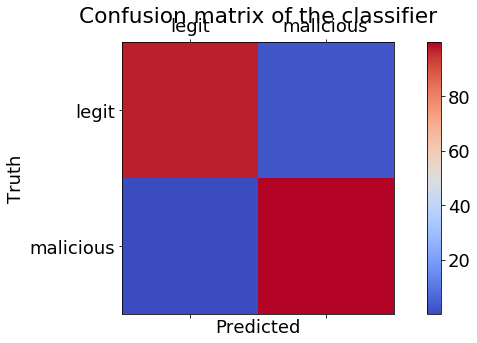

In [112]:
# Now plot the results of the 80/20 split in a confusion matrix
from sklearn.metrics import confusion_matrix
labels = ['legit', 'malicious']
cm = confusion_matrix(y_test, y_pred, labels)

def plot_cm(cm, labels):
    
    # Compute percentanges
    percent = (cm*100.0)/np.array(np.matrix(cm.sum(axis=1)).T)  # Derp, I'm sure there's a better way
    
    print('Confusion Matrix Stats')
    for i, label_i in enumerate(labels):
        for j, label_j in enumerate(labels):
            print("%s/%s: %.2f%% (%d/%d)" % (label_i, label_j, (percent[i][j]), cm[i][j], cm[i].sum()))

    # Show confusion matrix
    # Thanks kermit666 from stackoverflow :)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.grid(b=False)
    cax = ax.matshow(percent, cmap='coolwarm')
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()

plot_cm(cm, labels)

In [135]:
# Documentation in sqlparse for the mapping can be found here: 
# https://github.com/andialbrecht/sqlparse/blob/master/sqlparse/keywords.py
# or here
# https://github.com/andialbrecht/sqlparse/blob/master/sqlparse/lexer.py

# Here we look at example of the SQL sequence that G-Test has indicated are good
# indicators of SQL injections.
dataframe[dataframe['sequences'].map(lambda x: "('Single', 'Identifier')" in x)].head()

,raw_sql,type,parsed_sql,sequences
0,'; exec master..xp_cmdshell 'ping 10.10.1.2'--,malicious,"[Single, Identifier, Float, Float, Float, Erro...","[('Single',), ('Identifier',), ('Float',), ('F..."
1033,anything' or 'x'='x,malicious,"[Identifier, Single, Identifier, Single, Ident...","[('Identifier',), ('Single',), ('Identifier',)..."
1038,'; exec master..xp_cmdshell 'ping aaa.bbb.ccc....,malicious,"[Single, Identifier, Error, Single]","[('Single',), ('Identifier',), ('Error',), ('S..."
1043,'; if not(select system_user) <> 'sa' waitfor ...,malicious,"[Single, Identifier, Single, Integer, Punctuat...","[('Single',), ('Identifier',), ('Single',), ('..."
1044,'; if is_srvrolemember('sysadmin') > 0 waitfor...,malicious,"[Single, Identifier, Single, Integer, Punctuat...","[('Single',), ('Identifier',), ('Single',), ('..."


<div style="float: right; padding:10px;"><img src="files/images/sad_party.jpg" width="200px"></div>
<font size=4>Yea! Those scores look totally awesome, lets have a Party! But later we realize that if your system is processing 1 Million sql statements that with the predictive performance above you'll get tens of thousands of false positives, so now it's a Sad Party :(
<br><br>
But our Mom said we were still cool.. so we're going to exercise another nice feature. Most of the machine learning algorithm in scikit learn have a companion function to the normal 'predict' function... called 'predict_proba' where the model will compute the probability of that class matching based on various metrics. For instance, random forest bases the probability function on how many of the trees in the forest voted one way or the other.. so a probability of .7 means that 70% of the trees voted one way and the other 30% voted the other way.</font>

Confusion Matrix Stats
legit/legit: 98.60% (212/215)
legit/malicious: 1.40% (3/215)
malicious/legit: 0.62% (16/2564)
malicious/malicious: 99.38% (2548/2564)


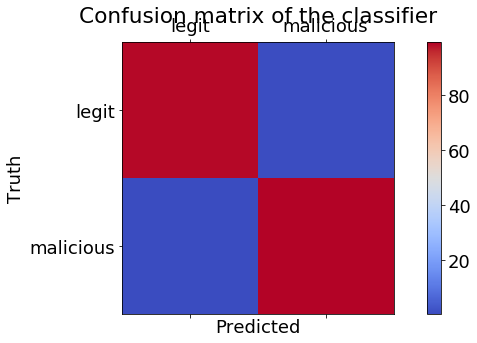

In [136]:
# Compute the precition probabilities and use them to mimimize our false positives
# Note: This is simply a trade off, it means we'll miss a few of the malicious
# ones but typically false alarms are a death blow to any new 'fancy stuff' so
# we definitely want to mimimize the false alarms.
y_probs = clf.predict_proba(X_test)[:,1]
thres = .95 # This can be set to whatever you'd like
y_pred[y_probs<thres] = 'legit'
y_pred[y_probs>=thres] = 'malicious'
cm = confusion_matrix(y_test, y_pred, labels)
plot_cm(cm, labels)

由于测试数据集的关系，这个分类器更倾向于报告分类结果为：恶意，主要原因是数据集中恶意样本占比非常高

In [137]:
# We can also look at what features the learning algorithm thought were the most important
importances = zip(['length', 'entropy', 'legit_g', 'malicious_g'], clf.feature_importances_)
importances

# From the list below we see our feature importance scores. There's a lot of feature selection,
# sensitivity study, etc stuff that you could do if you wanted at this point.

In [138]:
# Now were going to just do some post analysis on how the ML algorithm performed.
# Lets look at the legit samples that were misclassified as malicious
test_set = dataframe.loc[index_test]
test_set['pred'] = y_pred
misclassified = test_set[(test_set['type']=='legit') & (test_set['pred']=='malicious')]
misclassified.head()

,raw_sql,type,parsed_sql,sequences,pred
347,GoogleGitSign in eclipse / datatools/org.eclip...,legit,"[Identifier, Keyword, Operation, Operator, Ope...","[('Identifier',), ('Keyword',), ('Operation',)...",malicious
117,CREATE TABLE sylph.users ( id SERIAL PRIMARY K...,legit,"[DDL, Keyword, Identifier, Punctuation, Identi...","[('DDL',), ('Keyword',), ('Identifier',), ('Pu...",malicious
610,"SELECT dept, number, SUBSTR(title, 1, 12) AS s...",legit,"[DML, Identifier, Punctuation, Builtin, Punctu...","[('DML',), ('Identifier',), ('Punctuation',), ...",malicious


In [139]:
# Discussion for how to use the resulting models.
# Typically Machine Learning comes in two phases
#    - Training of the Model
#    - Evaluation of new observations against the Model
# This notebook is about exploration of the data and training the model.
# After you have a model that you are satisfied with, just 'pickle' it
# at the end of the your training script and then in a separate
# evaluation script 'unpickle' it and evaluate/score new observations
# coming in (through a file, or ZeroMQ, or whatever...)
#
# In this case we'd have to pickle the RandomForest classifier.
# See 'test_it' below for how to use them in evaluation mode.


# test_it shows how to do evaluation, also fun for manual testing below :)
def test_it(sql):
    parsed_sql = parse_it(sql)
    ngram_list = ngrams(parsed_sql, 3)
    malicious_g = g_aggregate(ngram_list, 'malicious_g')
    legit_g = g_aggregate(ngram_list, 'legit_g')
    _X = [len(parsed_sql), entropy(sql), legit_g, malicious_g]
    #print(np.asarray(_X).reshape(1, -1))
    print('%-40s: %s' % (sql, clf.predict(np.asarray(_X).reshape(1, -1))[0]))

In [140]:
test_it('select * from employees')
test_it("'; exec master..xp_cmdshell")
test_it("'any 'x'='x'")
test_it('from dorseys mom xp_cmdshell biache')
test_it('select * from your_mom')

select * from employees                 : legit
'; exec master..xp_cmdshell             : malicious
'any 'x'='x'                            : malicious
from dorseys mom xp_cmdshell biache     : malicious
select * from your_mom                  : legit


In [141]:
# 使用非./data目录中的样本数据测试
with open('cheatsheet.txt') as cheatsheets:
    for case in cheatsheets:
        test_it(case.strip('\n'))

hello                                   : legit
233                                     : malicious
3'                                      : malicious
3 order by 1/*                          : malicious
3 order by 2/*                          : malicious
3 order by 3/*                          : malicious
3 order by 4/*                          : malicious
3 order by 5/*                          : malicious
3 union all select 1,2,3,4/*            : malicious
3 union all select 1,2,3,4--            : malicious
3 union all select 1,2,@@version,4/*    : malicious
3 union all select 1,2,password,4,5 from admin/*: malicious
3 union all select 1,2,concat(username,0x3a,password),4,5 from admin/*: malicious
3 and 1=1                               : malicious
3 and 1=2                               : malicious
3 and substring(@@version,1,1)=4        : malicious
3 and substsubstringring(@@versversionion,1,1)=4: malicious
3 and substring(@@version,1,1)=5        : malicious
3 and (select 1)=1    

### Conclusions:
The combination of IPython, Pandas and Scikit Learn let us pull in some junky SQL data, clean it up, plot it, understand it and slap it with some machine learning!

Clearly a lot more formality could be used, plotting learning curves, adjusting for overfitting, feature selection, on and on... there are some really great machine learning resources that cover this deeper material. In particular we highly recommend the work and presentations of Olivier Grisel at INRIA Saclay. http://ogrisel.com/

 - W. G.J. Halfond, J. Viegas, and A. Orso, "A Classiﬁcation of SQL Injection Attacks and Countermeasure",[http://www-bcf.usc.edu/~halfond/papers/halfond06issse.pdf]
 - A. K. Baranwa1, "Approaches to detect SQL injection and XSS in web applications," 2012. [http://blogs.ubc.ca/computersecurity/files/2012/04/ABaranwal_ApproachesToDetectSQLinjection_XSSinWebApplication.pdf]

### Recommended Readings

* [Time-Based Blind SQL Injection using Heavy Queries | A practical approach for MS SQL Server, MS Access, Oracle and MySQL databases and Marathon Tool](https://www.defcon.org/images/defcon-16/dc16-presentations/alonso-parada/defcon-16-alonso-parada-wp.pdf)
* [free online reference about SQL injection attacks](http://www.sqlinjection.net/)
* [SQL Injection Wiki | grouped by DBs](http://www.sqlinjectionwiki.com/)

### 后记

* 上述机器学习方法建立的分类器模型，如果需要获得良好的分类性能，数据质量和标记质量至关重要！其次是特征工程的作用，至关重要！
* 由于每次训练过程是随机划分训练数据集和测试数据集，所以上述notebook脚本多次重复运行得到的分类器的分类性能会有细微差异。